# Config

In [1]:
import pandas as pd

import pingouin as pg
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.sandbox.stats.runs import mcnemar
from scipy.stats import ranksums, pearsonr, spearmanr, kendalltau, wilcoxon, ttest_rel, ttest_ind
from cliffs_delta import cliffs_delta

from matplotlib import pyplot as plt

# Load data

In [2]:
data_df = pd.read_csv(f'./final_data/filtered_participants.csv')
data_df.head()

,id,participant_type,participant_group,duration,sessions,d1_reading_time,d1_q1,d1_q2,d1_q3,d1_q4,...,d2_rate,d2_correctness,d2_insecurity,d2_insecurity_count,age_range,education_fields,education_level,employment,employment_fields,italian_knowledge
0,1,ADMINISTRATIVE,A,1020,1,499.972,1.0,3.0,1.0,1.0,...,2.0,5,False,0,25-34,JURIDICAL,BACHELOR,EMPLOYEE,ADMINISTRATIVE,M
1,10,ADMINISTRATIVE,B,985,1,383.870,1.0,3.0,3.0,1.0,...,3.0,3,False,0,35-44,OTHER,HIGH,EMPLOYEE,IT | OTHER,M
2,11,ADMINISTRATIVE,A,878,1,309.125,1.0,3.0,3.0,1.0,...,3.0,5,False,0,45-54,JURIDICAL,MASTER,EMPLOYEE,ADMINISTRATIVE,M
3,13,ADMINISTRATIVE,C,1016,1,416.598,1.0,3.0,1.0,1.0,...,3.0,5,False,0,45-54,OTHER,HIGH,EMPLOYEE,ADMINISTRATIVE,M
4,14,ADMINISTRATIVE,B,1138,1,323.449,1.0,3.0,2.0,1.0,...,3.0,3,False,0,55-64,JURIDICAL,MASTER,EMPLOYEE,ADMINISTRATIVE,M


In [3]:
data_df['participant_type'].value_counts()

participant_type
REGULAR           41
FOREIGNER         29
ADMINISTRATIVE    15
Name: count, dtype: int64

# DF Build

In [4]:
participants_dfs_names =[
    'ALL',
    'REGULAR',
    'FOREIGNER',
    'ADMINISTRATIVE',
]
participants_dfs = [
    data_df,
    data_df[data_df['participant_type'] == 'REGULAR'],
    data_df[data_df['participant_type'] == 'FOREIGNER'],
    data_df[data_df['participant_type'] == 'ADMINISTRATIVE'],
]

In [5]:
def build_df(_participant_df, penalty_mode='no', fix_d1_q2=False, fix_d2_q4=False):
  o = []
  for participant in _participant_df.to_dict('records'):
    d1_rate = participant['d1_rate']
    d2_rate = participant['d2_rate']

    d1_insecurity = participant['d1_insecurity']
    d2_insecurity = participant['d2_insecurity']

    d1_full_insecurity = participant['d1_insecurity_count']
    d2_full_insecurity = participant['d2_insecurity_count']

    d1_reading_time = participant['d1_reading_time']
    d2_reading_time = participant['d2_reading_time']

    d1_q1_correctness = participant['d1_q1'] == 1
    d1_q2_correctness = participant['d1_q2'] == 1
    d1_q3_correctness = participant['d1_q3'] == 1
    d1_q4_correctness = participant['d1_q4'] == 1
    d1_q5_correctness = participant['d1_q5'] == 1
    d1_q6_correctness = participant['d1_q6'] == 1

    d2_q1_correctness = participant['d2_q1'] == 1
    d2_q2_correctness = participant['d2_q2'] == 1
    d2_q3_correctness = participant['d2_q3'] == 1
    d2_q4_correctness = participant['d2_q4'] == 1
    d2_q5_correctness = participant['d2_q5'] == 1
    d2_q6_correctness = participant['d2_q6'] == 1

    # d1_correctness = sum([d1_q1_correctness, d1_q2_correctness, d1_q3_correctness, d1_q4_correctness, d1_q5_correctness, d1_q6_correctness])
    # d2_correctness = sum([d2_q1_correctness, d2_q2_correctness, d2_q3_correctness, d2_q4_correctness, d2_q5_correctness, d2_q6_correctness])

    d1_correctness = sum([d1_q1_correctness, d1_q2_correctness, d1_q3_correctness, d1_q4_correctness, d1_q5_correctness])
    d2_correctness = sum([d2_q1_correctness, d2_q2_correctness, d2_q3_correctness, d2_q4_correctness, d2_q6_correctness])

    # if fix_d1_q2:
    #   d1_q2_correctness = participant['d1_q2'] == 2
    #   if participant['d1_q2'] == 2:
    #     d1_correctness += 1
    #   if participant['d1_q2'] == 1:
    #     d1_correctness -= 1

    # if fix_d2_q4:
    #   d2_q4_correctness = participant['d2_q4'] == 2
    #   if participant['d2_q4'] == 2:
    #     d2_correctness += 1
    #   if participant['d2_q4'] == 1:
    #     d2_correctness -= 1

    if penalty_mode == 'soft':
      d1_correctness -= 0.25 * (4 - sum([d1_q1_correctness, d1_q2_correctness, d1_q3_correctness, d1_q4_correctness]))
      d2_correctness -= 0.25 * (4 - sum([d2_q1_correctness, d2_q2_correctness, d2_q3_correctness, d2_q4_correctness]))

    if penalty_mode == 'soft2':
      d1_correctness -= 0.5 * (4 - sum([d1_q1_correctness, d1_q2_correctness, d1_q3_correctness, d1_q4_correctness]))
      d2_correctness -= 0.5 * (4 - sum([d2_q1_correctness, d2_q2_correctness, d2_q3_correctness, d2_q4_correctness]))

    if penalty_mode == 'soft3':
      d1_correctness -= 1 * (4 - sum([d1_q1_correctness, d1_q2_correctness, d1_q3_correctness, d1_q4_correctness]))
      d2_correctness -= 1 * (4 - sum([d2_q1_correctness, d2_q2_correctness, d2_q3_correctness, d2_q4_correctness]))

    if penalty_mode == 'hard':
      if any([not d1_q1_correctness, not d1_q2_correctness, not d1_q3_correctness, not d1_q4_correctness]):
        d1_correctness = 0
      if any([not d2_q1_correctness, not d2_q2_correctness, not d2_q3_correctness, not d2_q4_correctness]):
        d2_correctness = 0

    if participant['participant_group'] == 'A':
      o.append({
          'subject': participant['id'],
          'lab': '1',
          'task': 'D1',
          'treatment': 'ORIGINAL',
          'reading_time': d1_reading_time,
          'correctness': d1_correctness,
          'insecurity': d1_insecurity,
          'full_insecurity': d1_full_insecurity,
          'rate': d1_rate,
          'q1': d1_q1_correctness,
          'q2': d1_q2_correctness,
          'q3': d1_q3_correctness,
          'q4': d1_q4_correctness,
          'q5': d1_q5_correctness,
          'q6': d1_q6_correctness,
          'exp': participant['participant_type'],
      })
      o.append({
          'subject': participant['id'],
          'lab': '2',
          'task': 'D2',
          'treatment': 'SEMPL',
          'reading_time': d2_reading_time,
          'correctness': d2_correctness,
          'insecurity': d2_insecurity,
          'full_insecurity': d2_full_insecurity,
          'rate': d2_rate,
          'q1': d2_q1_correctness,
          'q2': d2_q2_correctness,
          'q3': d2_q3_correctness,
          'q4': d2_q4_correctness,
          'q5': d2_q5_correctness,
          'q6': d2_q6_correctness,
          'exp': participant['participant_type'],
      })
    elif participant['participant_group'] == 'B':
      o.append({
          'subject': participant['id'],
          'lab': '1',
          'task': 'D1',
          'treatment': 'SEMPL',
          'reading_time': d1_reading_time,
          'correctness': d1_correctness,
          'insecurity': d1_insecurity,
          'full_insecurity': d1_full_insecurity,
          'rate': d1_rate,
          'q1': d1_q1_correctness,
          'q2': d1_q2_correctness,
          'q3': d1_q3_correctness,
          'q4': d1_q4_correctness,
          'q5': d1_q5_correctness,
          'q6': d1_q6_correctness,
          'exp': participant['participant_type'],
      })
      o.append({
          'subject': participant['id'],
          'lab': '2',
          'task': 'D2',
          'treatment': 'ORIGINAL',
          'reading_time': d2_reading_time,
          'correctness': d2_correctness,
          'insecurity': d2_insecurity,
          'full_insecurity': d2_full_insecurity,
          'rate': d2_rate,
          'q1': d2_q1_correctness,
          'q2': d2_q2_correctness,
          'q3': d2_q3_correctness,
          'q4': d2_q4_correctness,
          'q5': d2_q5_correctness,
          'q6': d2_q6_correctness,
          'exp': participant['participant_type'],
      })
    elif participant['participant_group'] == 'C':
      o.append({
          'subject': participant['id'],
          'lab': '1',
          'task': 'D2',
          'treatment': 'ORIGINAL',
          'reading_time': d2_reading_time,
          'correctness': d2_correctness,
          'insecurity': d2_insecurity,
          'full_insecurity': d2_full_insecurity,
          'rate': d2_rate,
          'q1': d2_q1_correctness,
          'q2': d2_q2_correctness,
          'q3': d2_q3_correctness,
          'q4': d2_q4_correctness,
          'q5': d2_q5_correctness,
          'q6': d2_q6_correctness,
          'exp': participant['participant_type'],
      })
      o.append({
          'subject': participant['id'],
          'lab': '2',
          'task': 'D1',
          'treatment': 'SEMPL',
          'reading_time': d1_reading_time,
          'correctness': d1_correctness,
          'insecurity': d1_insecurity,
          'full_insecurity': d1_full_insecurity,
          'rate': d1_rate,
          'q1': d1_q1_correctness,
          'q2': d1_q2_correctness,
          'q3': d1_q3_correctness,
          'q4': d1_q4_correctness,
          'q5': d1_q5_correctness,
          'q6': d1_q6_correctness,
          'exp': participant['participant_type'],
      })
    elif participant['participant_group'] == 'D':
      o.append({
          'subject': participant['id'],
          'lab': '1',
          'task': 'D2',
          'treatment': 'SEMPL',
          'reading_time': d2_reading_time,
          'correctness': d2_correctness,
          'insecurity': d2_insecurity,
          'full_insecurity': d2_full_insecurity,
          'rate': d2_rate,
          'q1': d2_q1_correctness,
          'q2': d2_q2_correctness,
          'q3': d2_q3_correctness,
          'q4': d2_q4_correctness,
          'q5': d2_q5_correctness,
          'q6': d2_q6_correctness,
          'exp': participant['participant_type'],
      })
      o.append({
          'subject': participant['id'],
          'lab': '2',
          'task': 'D1',
          'treatment': 'ORIGINAL',
          'reading_time': d1_reading_time,
          'correctness': d1_correctness,
          'insecurity': d1_insecurity,
          'full_insecurity': d1_full_insecurity,
          'rate': d1_rate,
          'q1': d1_q1_correctness,
          'q2': d1_q2_correctness,
          'q3': d1_q3_correctness,
          'q4': d1_q4_correctness,
          'q5': d1_q5_correctness,
          'q6': d1_q6_correctness,
          'exp': participant['participant_type'],
      })
    else:
      raise ValueError('Unknown participant group')

  return pd.DataFrame(o)

In [6]:
build_df(data_df, penalty_mode='soft2')

,subject,lab,task,treatment,reading_time,correctness,insecurity,full_insecurity,rate,q1,q2,q3,q4,q5,q6,exp
0,1,1,D1,ORIGINAL,499.972,3.5,False,0,4.0,True,False,True,True,True,True,ADMINISTRATIVE
1,1,2,D2,SEMPL,226.652,3.5,False,0,2.0,True,True,True,False,True,True,ADMINISTRATIVE
2,10,1,D1,SEMPL,383.870,2.0,False,0,3.0,True,False,False,True,True,True,ADMINISTRATIVE
3,10,2,D2,ORIGINAL,233.470,1.0,False,0,3.0,True,False,False,True,True,False,ADMINISTRATIVE
4,11,1,D1,ORIGINAL,309.125,1.0,False,0,3.0,True,False,False,True,False,False,ADMINISTRATIVE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,UEFSVEVDSVBBTlRFXzUw,2,D2,SEMPL,242.522,3.5,False,0,3.0,True,True,True,False,True,True,FOREIGNER
166,UEFSVEVDSVBBTlRFXzUx,1,D1,SEMPL,1157.067,2.0,False,0,2.0,True,False,False,True,True,True,FOREIGNER
167,UEFSVEVDSVBBTlRFXzUx,2,D2,ORIGINAL,612.700,3.5,False,0,3.0,True,True,True,False,True,True,FOREIGNER
168,UEFSVEVDSVBBTlRFXzY=,1,D2,SEMPL,247.971,1.0,True,1,4.0,True,True,False,False,True,False,ADMINISTRATIVE


# D1

## reading time

In [7]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')]['reading_time']
  d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')]['reading_time']

  results.append({
      'name': name,
      'original': round(d1_original.mean() / 60.0, 2),
      'sempl': round(d1_sempl.mean() / 60.0, 2),
      'ranksums': ranksums(d1_original, d1_sempl)[1],
      'effsize': cliffs_delta(d1_original, d1_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,9.66,10.77,0.867291,negligible
1,REGULAR,10.75,12.64,0.875645,negligible
2,FOREIGNER,7.86,10.95,0.205633,small
3,ADMINISTRATIVE,10.12,5.52,0.082579,large


## rate (higher is harder)

In [8]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')]['rate']
  d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')]['rate']

  results.append({
      'name': name,
      'original': round(d1_original.mean(), 2),
      'sempl': round(d1_sempl.mean(), 2),
      'ranksums': ranksums(d1_original, d1_sempl)[1],
      'effsize': cliffs_delta(d1_original, d1_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,3.44,3.32,0.438968,negligible
1,REGULAR,3.30,3.05,0.321628,small
2,FOREIGNER,3.71,3.93,0.526843,negligible
3,ADMINISTRATIVE,3.29,2.88,0.271589,medium


## correctness


In [9]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard']:
    for fix_d1_q2 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d1_q2=fix_d1_q2)

      d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')]['correctness']
      d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')]['correctness']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d1_q2': fix_d1_q2,
          'original': round(d1_original.mean(), 2),
          'sempl': round(d1_sempl.mean(), 2),
          'ranksums': ranksums(d1_original, d1_sempl)[1],
          'effsize': cliffs_delta(d1_original, d1_sempl)[1]
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d1_q2,original,sempl,ranksums,effsize
0,no,False,2.93,2.84,0.606908,negligible
1,no,True,2.93,2.84,0.606908,negligible
2,soft,False,2.51,2.36,0.346686,negligible
3,soft,True,2.51,2.36,0.346686,negligible
4,soft2,False,2.10,1.89,0.346686,negligible
5,soft2,True,2.10,1.89,0.346686,negligible
6,soft3,False,1.27,0.93,0.346686,negligible
7,soft3,True,1.27,0.93,0.346686,negligible
8,hard,False,0.34,0.34,0.978951,negligible
9,hard,True,0.34,0.34,0.978951,negligible


=== REGULAR ===


,penalty_mode,fix_d1_q2,original,sempl,ranksums,effsize
0,no,False,2.95,3.19,0.505992,negligible
1,no,True,2.95,3.19,0.505992,negligible
2,soft,False,2.52,2.77,0.734560,negligible
3,soft,True,2.52,2.77,0.734560,negligible
4,soft2,False,2.10,2.36,0.734560,negligible
5,soft2,True,2.10,2.36,0.734560,negligible
6,soft3,False,1.25,1.52,0.734560,negligible
7,soft3,True,1.25,1.52,0.734560,negligible
8,hard,False,0.25,0.48,0.804305,negligible
9,hard,True,0.25,0.48,0.804305,negligible


=== FOREIGNER ===


,penalty_mode,fix_d1_q2,original,sempl,ranksums,effsize
0,no,False,2.57,2.13,0.275234,small
1,no,True,2.57,2.13,0.275234,small
2,soft,False,2.12,1.52,0.143725,small
3,soft,True,2.12,1.52,0.143725,small
4,soft2,False,1.68,0.90,0.143725,small
5,soft2,True,1.68,0.90,0.143725,small
6,soft3,False,0.79,-0.33,0.143725,small
7,soft3,True,0.79,-0.33,0.143725,small
8,hard,False,0.29,0.00,0.743421,negligible
9,hard,True,0.29,0.00,0.743421,negligible


=== ADMINISTRATIVE ===


,penalty_mode,fix_d1_q2,original,sempl,ranksums,effsize
0,no,False,3.57,3.25,0.451913,small
1,no,True,3.57,3.25,0.451913,small
2,soft,False,3.25,2.88,0.524450,small
3,soft,True,3.25,2.88,0.524450,small
4,soft2,False,2.93,2.50,0.524450,small
5,soft2,True,2.93,2.50,0.524450,small
6,soft3,False,2.29,1.75,0.524450,small
7,soft3,True,2.29,1.75,0.524450,small
8,hard,False,0.71,0.62,0.953857,negligible
9,hard,True,0.71,0.62,0.953857,negligible


## insecurity

In [10]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')]['insecurity']
  d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')]['insecurity']

  results.append({
      'name': name,
      'original (%)': round(d1_original.mean() * 100, 2),
      'sempl (%)': round(d1_sempl.mean() * 100, 2),
      'ttest_ind': ttest_ind(d1_original, d1_sempl)[1],
      'effsize': cliffs_delta(d1_original, d1_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original (%),sempl (%),ttest_ind,effsize
0,ALL,19.51,20.45,NaN,negligible
1,REGULAR,20.00,14.29,NaN,negligible
2,FOREIGNER,28.57,33.33,NaN,negligible
3,ADMINISTRATIVE,0.00,12.50,NaN,negligible


## full_insecurity

In [11]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')]['full_insecurity']
  d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')]['full_insecurity']

  results.append({
      'name': name,
      'original': round(d1_original.mean(), 2),
      'sempl': round(d1_sempl.mean(), 2),
      'ranksums': ranksums(d1_original, d1_sempl)[1],
      'effsize': cliffs_delta(d1_original, d1_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,0.27,0.27,0.947409,negligible
1,REGULAR,0.25,0.19,0.764220,negligible
2,FOREIGNER,0.43,0.47,0.844300,negligible
3,ADMINISTRATIVE,0.00,0.12,0.685443,negligible


## rate <=> correctness

In [12]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard']:
    for fix_d1_q2 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d1_q2=True)

      d1_correctness = _df[_df['task'] == 'D1']['correctness']
      d1_rate = _df[_df['task'] == 'D1']['rate']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d1_q2': fix_d1_q2,
          'correctness': round(d1_correctness.mean(), 2),
          'rate': round(d1_rate.mean(), 2),
          'pearsonr': pearsonr(d1_correctness, d1_rate)[0],
          'spearmanr': spearmanr(d1_correctness, d1_rate)[0],
          'kendalltau': kendalltau(d1_correctness, d1_rate)[0],
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d1_q2,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,2.88,3.38,-0.257221,-0.231013,-0.197243
1,no,True,2.88,3.38,-0.257221,-0.231013,-0.197243
2,soft,False,2.44,3.38,-0.267317,-0.250502,-0.206620
3,soft,True,2.44,3.38,-0.267317,-0.250502,-0.206620
4,soft2,False,1.99,3.38,-0.273624,-0.250502,-0.206620
5,soft2,True,1.99,3.38,-0.273624,-0.250502,-0.206620
6,soft3,False,1.09,3.38,-0.280776,-0.250502,-0.206620
7,soft3,True,1.09,3.38,-0.280776,-0.250502,-0.206620
8,hard,False,0.34,3.38,-0.072234,-0.050866,-0.046568
9,hard,True,0.34,3.38,-0.072234,-0.050866,-0.046568


=== REGULAR ===


,penalty_mode,fix_d1_q2,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,3.07,3.17,-0.125290,-0.153283,-0.138558
1,no,True,3.07,3.17,-0.125290,-0.153283,-0.138558
2,soft,False,2.65,3.17,-0.133879,-0.160651,-0.137701
3,soft,True,2.65,3.17,-0.133879,-0.160651,-0.137701
4,soft2,False,2.23,3.17,-0.139417,-0.160651,-0.137701
5,soft2,True,2.23,3.17,-0.139417,-0.160651,-0.137701
6,soft3,False,1.39,3.17,-0.145968,-0.160651,-0.137701
7,soft3,True,1.39,3.17,-0.145968,-0.160651,-0.137701
8,hard,False,0.37,3.17,0.051873,0.071327,0.066284
9,hard,True,0.37,3.17,0.051873,0.071327,0.066284


=== FOREIGNER ===


,penalty_mode,fix_d1_q2,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,2.34,3.83,-0.136669,-0.110234,-0.090978
1,no,True,2.34,3.83,-0.136669,-0.110234,-0.090978
2,soft,False,1.81,3.83,-0.164656,-0.185885,-0.143581
3,soft,True,1.81,3.83,-0.164656,-0.185885,-0.143581
4,soft2,False,1.28,3.83,-0.183889,-0.185885,-0.143581
5,soft2,True,1.28,3.83,-0.183889,-0.185885,-0.143581
6,soft3,False,0.21,3.83,-0.208259,-0.185885,-0.143581
7,soft3,True,0.21,3.83,-0.208259,-0.185885,-0.143581
8,hard,False,0.14,3.83,0.035714,0.035540,0.032953
9,hard,True,0.14,3.83,0.035714,0.035540,0.032953


=== ADMINISTRATIVE ===


,penalty_mode,fix_d1_q2,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,3.40,3.07,-0.317258,-0.271664,-0.245256
1,no,True,3.40,3.07,-0.317258,-0.271664,-0.245256
2,soft,False,3.05,3.07,-0.312484,-0.267163,-0.236113
3,soft,True,3.05,3.07,-0.312484,-0.267163,-0.236113
4,soft2,False,2.70,3.07,-0.307863,-0.267163,-0.236113
5,soft2,True,2.70,3.07,-0.307863,-0.267163,-0.236113
6,soft3,False,2.00,3.07,-0.300150,-0.267163,-0.236113
7,soft3,True,2.00,3.07,-0.300150,-0.267163,-0.236113
8,hard,False,0.67,3.07,-0.387567,-0.380750,-0.366900
9,hard,True,0.67,3.07,-0.387567,-0.380750,-0.366900


## reading_time <=> correctness

In [13]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard']:
    for fix_d1_q2 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d1_q2=fix_d1_q2)

      d1_correctness = _df[_df['task'] == 'D1']['correctness']
      d1_reading_time = _df[_df['task'] == 'D1']['reading_time']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d1_q2': fix_d1_q2,
          'correctness': round(d1_correctness.mean(), 2),
          'reading_time': round(d1_reading_time.mean(), 2),
          'pearsonr': pearsonr(d1_correctness, d1_reading_time)[0],
          'spearmanr': spearmanr(d1_correctness, d1_reading_time)[0],
          'kendalltau': kendalltau(d1_correctness, d1_reading_time)[0],
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d1_q2,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,2.88,613.99,0.095669,0.190695,0.140765
1,no,True,2.88,613.99,0.095669,0.190695,0.140765
2,soft,False,2.44,613.99,0.104509,0.188393,0.140750
3,soft,True,2.44,613.99,0.104509,0.188393,0.140750
4,soft2,False,1.99,613.99,0.110470,0.188393,0.140750
5,soft2,True,1.99,613.99,0.110470,0.188393,0.140750
6,soft3,False,1.09,613.99,0.117868,0.188393,0.140750
7,soft3,True,1.09,613.99,0.117868,0.188393,0.140750
8,hard,False,0.34,613.99,-0.043038,-0.032979,-0.026765
9,hard,True,0.34,613.99,-0.043038,-0.032979,-0.026765


=== REGULAR ===


,penalty_mode,fix_d1_q2,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,3.07,703.17,0.010241,0.097909,0.069454
1,no,True,3.07,703.17,0.010241,0.097909,0.069454
2,soft,False,2.65,703.17,0.033939,0.113946,0.091333
3,soft,True,2.65,703.17,0.033939,0.113946,0.091333
4,soft2,False,2.23,703.17,0.050516,0.113946,0.091333
5,soft2,True,2.23,703.17,0.050516,0.113946,0.091333
6,soft3,False,1.39,703.17,0.071880,0.113946,0.091333
7,soft3,True,1.39,703.17,0.071880,0.113946,0.091333
8,hard,False,0.37,703.17,-0.077855,0.000000,0.000000
9,hard,True,0.37,703.17,-0.077855,0.000000,0.000000


=== FOREIGNER ===


,penalty_mode,fix_d1_q2,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,2.34,567.57,0.353765,0.306877,0.238595
1,no,True,2.34,567.57,0.353765,0.306877,0.238595
2,soft,False,1.81,567.57,0.326575,0.254867,0.193025
3,soft,True,1.81,567.57,0.326575,0.254867,0.193025
4,soft2,False,1.28,567.57,0.306133,0.254867,0.193025
5,soft2,True,1.28,567.57,0.306133,0.254867,0.193025
6,soft3,False,0.21,567.57,0.277960,0.254867,0.193025
7,soft3,True,0.21,567.57,0.277960,0.254867,0.193025
8,hard,False,0.14,567.57,-0.219079,-0.293640,-0.243855
9,hard,True,0.14,567.57,-0.219079,-0.293640,-0.243855


=== ADMINISTRATIVE ===


,penalty_mode,fix_d1_q2,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,3.40,459.96,0.583223,0.588684,0.470162
1,no,True,3.40,459.96,0.583223,0.588684,0.470162
2,soft,False,3.05,459.96,0.586143,0.619420,0.495743
3,soft,True,3.05,459.96,0.586143,0.619420,0.495743
4,soft2,False,2.70,459.96,0.586119,0.619420,0.495743
5,soft2,True,2.70,459.96,0.586119,0.619420,0.495743
6,soft3,False,2.00,459.96,0.583231,0.619420,0.495743
7,soft3,True,2.00,459.96,0.583231,0.619420,0.495743
8,hard,False,0.67,459.96,0.434928,0.226960,0.191390
9,hard,True,0.67,459.96,0.434928,0.226960,0.191390


## questions

In [14]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []

  _df = build_df(df)
  for question in ['q1', 'q2', 'q3', 'q4', 'q5',  'q6']:
    d1_original = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'ORIGINAL')][question]
    d1_sempl = _df[(_df['task'] == 'D1') & (_df['treatment'] == 'SEMPL')][question]

    results.append({
        'question': question,
        'original (%)': round(d1_original.mean() * 100, 2),
        'sempl (%)': round(d1_sempl.mean() * 100, 2),
        'ttest_ind': ttest_ind(d1_original, d1_sempl)[1],
        'effsize': cliffs_delta(d1_original, d1_sempl)[1]
    })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,question,original (%),sempl (%),ttest_ind,effsize
0,q1,87.80,88.64,NaN,negligible
1,q2,17.07,18.18,NaN,negligible
2,q3,53.66,50.00,NaN,negligible
3,q4,75.61,52.27,NaN,small
4,q5,58.54,75.00,NaN,small
5,q6,85.37,84.09,NaN,negligible


=== REGULAR ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,question,original (%),sempl (%),ttest_ind,effsize
0,q1,85.0,100.00,NaN,small
1,q2,15.0,19.05,NaN,negligible
2,q3,50.0,61.90,NaN,negligible
3,q4,80.0,52.38,NaN,small
4,q5,65.0,85.71,NaN,small
5,q6,90.0,90.48,NaN,negligible


=== FOREIGNER ===


,question,original (%),sempl (%),ttest_ind,effsize
0,q1,85.71,66.67,NaN,small
1,q2,14.29,6.67,NaN,negligible
2,q3,57.14,40.00,NaN,small
3,q4,64.29,40.00,NaN,small
4,q5,35.71,60.00,NaN,small
5,q6,78.57,73.33,NaN,negligible


=== ADMINISTRATIVE ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,question,original (%),sempl (%),ttest_ind,effsize
0,q1,100.00,100.0,NaN,negligible
1,q2,28.57,37.5,NaN,negligible
2,q3,57.14,37.5,NaN,small
3,q4,85.71,75.0,NaN,negligible
4,q5,85.71,75.0,NaN,negligible
5,q6,85.71,87.5,NaN,negligible


# D2

## reading time

In [15]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')]['reading_time']
  d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')]['reading_time']

  results.append({
      'name': name,
      'original': round(d2_original.mean() / 60.0, 2),
      'sempl': round(d2_sempl.mean() / 60.0, 2),
      'ranksums': ranksums(d2_original, d2_sempl)[1],
      'effsize': cliffs_delta(d2_original, d2_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,7.89,7.36,0.316054,negligible
1,REGULAR,7.58,5.72,0.137101,small
2,FOREIGNER,9.77,10.69,0.930443,negligible
3,ADMINISTRATIVE,5.19,5.38,0.816961,negligible


## rate (higher is harder)

In [16]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')]['rate']
  d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')]['rate']

  results.append({
      'name': name,
      'original': round(d2_original.mean(), 2),
      'sempl': round(d2_sempl.mean(), 2),
      'ranksums': ranksums(d2_original, d2_sempl)[1],
      'effsize': cliffs_delta(d2_original, d2_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,3.57,3.12,0.070030,small
1,REGULAR,3.00,2.70,0.210593,small
2,FOREIGNER,4.47,3.71,0.034284,medium
3,ADMINISTRATIVE,3.38,3.14,0.728454,negligible


## correctness

In [17]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard', 'exclude']:
    for fix_d2_q4 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d2_q4=fix_d2_q4)

      d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')]['correctness']
      d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')]['correctness']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d2_q4': fix_d2_q4,
          'original': round(d2_original.mean(), 2),
          'sempl': round(d2_sempl.mean(), 2),
          'ranksums': ranksums(d2_original, d2_sempl)[1],
          'effsize': cliffs_delta(d2_original, d2_sempl)[1]
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d2_q4,original,sempl,ranksums,effsize
0,no,False,3.09,3.15,0.751539,negligible
1,no,True,3.09,3.15,0.751539,negligible
2,soft,False,2.66,2.77,0.460054,negligible
3,soft,True,2.66,2.77,0.460054,negligible
4,soft2,False,2.23,2.39,0.460054,negligible
5,soft2,True,2.23,2.39,0.460054,negligible
6,soft3,False,1.36,1.63,0.460054,negligible
7,soft3,True,1.36,1.63,0.460054,negligible
8,hard,False,0.23,0.59,0.549812,negligible
9,hard,True,0.23,0.59,0.549812,negligible


=== REGULAR ===


,penalty_mode,fix_d2_q4,original,sempl,ranksums,effsize
0,no,False,3.48,3.25,0.505992,negligible
1,no,True,3.48,3.25,0.505992,negligible
2,soft,False,3.13,2.88,0.620206,negligible
3,soft,True,3.13,2.88,0.620206,negligible
4,soft2,False,2.79,2.50,0.620206,negligible
5,soft2,True,2.79,2.50,0.620206,negligible
6,soft3,False,2.10,1.75,0.620206,negligible
7,soft3,True,2.10,1.75,0.620206,negligible
8,hard,False,0.24,0.50,0.774187,negligible
9,hard,True,0.24,0.50,0.774187,negligible


=== FOREIGNER ===


,penalty_mode,fix_d2_q4,original,sempl,ranksums,effsize
0,no,False,2.53,2.79,0.432111,small
1,no,True,2.53,2.79,0.432111,small
2,soft,False,1.98,2.34,0.256487,small
3,soft,True,1.98,2.34,0.256487,small
4,soft2,False,1.43,1.89,0.256487,small
5,soft2,True,1.43,1.89,0.256487,small
6,soft3,False,0.33,1.00,0.256487,small
7,soft3,True,0.33,1.00,0.256487,small
8,hard,False,0.00,0.36,0.743421,negligible
9,hard,True,0.00,0.36,0.743421,negligible


=== ADMINISTRATIVE ===


,penalty_mode,fix_d2_q4,original,sempl,ranksums,effsize
0,no,False,3.12,3.57,0.417887,small
1,no,True,3.12,3.57,0.417887,small
2,soft,False,2.69,3.32,0.247160,medium
3,soft,True,2.69,3.32,0.247160,medium
4,soft2,False,2.25,3.07,0.247160,medium
5,soft2,True,2.25,3.07,0.247160,medium
6,soft3,False,1.38,2.57,0.247160,medium
7,soft3,True,1.38,2.57,0.247160,medium
8,hard,False,0.62,1.29,0.643429,negligible
9,hard,True,0.62,1.29,0.643429,negligible


## insecurity

In [18]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')]['insecurity']
  d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')]['insecurity']

  results.append({
      'name': name,
      'original': round(d2_original.mean(), 2),
      'sempl': round(d2_sempl.mean(), 2),
      'ttest_ind': ttest_ind(d2_original, d2_sempl)[1],
      'effsize': cliffs_delta(d2_original, d2_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ttest_ind,effsize
0,ALL,0.07,0.17,NaN,negligible
1,REGULAR,0.10,0.15,NaN,negligible
2,FOREIGNER,0.07,0.21,NaN,small
3,ADMINISTRATIVE,0.00,0.14,NaN,negligible


## full_insecurity

In [19]:
results = []
for name, df in zip(participants_dfs_names, participants_dfs):
  _df = build_df(df)

  d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')]['full_insecurity']
  d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')]['full_insecurity']

  results.append({
      'name': name,
      'original': round(d2_original.mean() / 60.0, 2),
      'sempl': round(d2_sempl.mean() / 60.0, 2),
      'ranksums': ranksums(d2_original, d2_sempl)[1],
      'effsize': cliffs_delta(d2_original, d2_sempl)[1]
  })

pd.DataFrame(results).head(20)

,name,original,sempl,ranksums,effsize
0,ALL,0.0,0.0,0.400966,negligible
1,REGULAR,0.0,0.0,0.744405,negligible
2,FOREIGNER,0.0,0.0,0.484991,small
3,ADMINISTRATIVE,0.0,0.0,0.643429,negligible


## rate <=> correctness

In [20]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard', 'exclude']:
    for fix_d2_q4 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d2_q4=fix_d2_q4)

      d1_correctness = _df[_df['task'] == 'D1']['correctness']
      d1_rate = _df[_df['task'] == 'D1']['rate']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d2_q4': fix_d2_q4,
          'correctness': round(d1_correctness.mean(), 2),
          'rate': round(d1_rate.mean(), 2),
          'pearsonr': pearsonr(d1_correctness, d1_rate)[0],
          'spearmanr': spearmanr(d1_correctness, d1_rate)[0],
          'kendalltau': kendalltau(d1_correctness, d1_rate)[0],
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d2_q4,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,2.88,3.38,-0.257221,-0.231013,-0.197243
1,no,True,2.88,3.38,-0.257221,-0.231013,-0.197243
2,soft,False,2.44,3.38,-0.267317,-0.250502,-0.206620
3,soft,True,2.44,3.38,-0.267317,-0.250502,-0.206620
4,soft2,False,1.99,3.38,-0.273624,-0.250502,-0.206620
5,soft2,True,1.99,3.38,-0.273624,-0.250502,-0.206620
6,soft3,False,1.09,3.38,-0.280776,-0.250502,-0.206620
7,soft3,True,1.09,3.38,-0.280776,-0.250502,-0.206620
8,hard,False,0.34,3.38,-0.072234,-0.050866,-0.046568
9,hard,True,0.34,3.38,-0.072234,-0.050866,-0.046568


=== REGULAR ===


,penalty_mode,fix_d2_q4,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,3.07,3.17,-0.125290,-0.153283,-0.138558
1,no,True,3.07,3.17,-0.125290,-0.153283,-0.138558
2,soft,False,2.65,3.17,-0.133879,-0.160651,-0.137701
3,soft,True,2.65,3.17,-0.133879,-0.160651,-0.137701
4,soft2,False,2.23,3.17,-0.139417,-0.160651,-0.137701
5,soft2,True,2.23,3.17,-0.139417,-0.160651,-0.137701
6,soft3,False,1.39,3.17,-0.145968,-0.160651,-0.137701
7,soft3,True,1.39,3.17,-0.145968,-0.160651,-0.137701
8,hard,False,0.37,3.17,0.051873,0.071327,0.066284
9,hard,True,0.37,3.17,0.051873,0.071327,0.066284


=== FOREIGNER ===


,penalty_mode,fix_d2_q4,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,2.34,3.83,-0.136669,-0.110234,-0.090978
1,no,True,2.34,3.83,-0.136669,-0.110234,-0.090978
2,soft,False,1.81,3.83,-0.164656,-0.185885,-0.143581
3,soft,True,1.81,3.83,-0.164656,-0.185885,-0.143581
4,soft2,False,1.28,3.83,-0.183889,-0.185885,-0.143581
5,soft2,True,1.28,3.83,-0.183889,-0.185885,-0.143581
6,soft3,False,0.21,3.83,-0.208259,-0.185885,-0.143581
7,soft3,True,0.21,3.83,-0.208259,-0.185885,-0.143581
8,hard,False,0.14,3.83,0.035714,0.035540,0.032953
9,hard,True,0.14,3.83,0.035714,0.035540,0.032953


=== ADMINISTRATIVE ===


,penalty_mode,fix_d2_q4,correctness,rate,pearsonr,spearmanr,kendalltau
0,no,False,3.40,3.07,-0.317258,-0.271664,-0.245256
1,no,True,3.40,3.07,-0.317258,-0.271664,-0.245256
2,soft,False,3.05,3.07,-0.312484,-0.267163,-0.236113
3,soft,True,3.05,3.07,-0.312484,-0.267163,-0.236113
4,soft2,False,2.70,3.07,-0.307863,-0.267163,-0.236113
5,soft2,True,2.70,3.07,-0.307863,-0.267163,-0.236113
6,soft3,False,2.00,3.07,-0.300150,-0.267163,-0.236113
7,soft3,True,2.00,3.07,-0.300150,-0.267163,-0.236113
8,hard,False,0.67,3.07,-0.387567,-0.380750,-0.366900
9,hard,True,0.67,3.07,-0.387567,-0.380750,-0.366900


## reading_time <=> correctness

In [21]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard', 'exclude']:
    for fix_d2_q4 in [False, True]:
      _df = build_df(df, penalty_mode, fix_d2_q4=fix_d2_q4)

      d1_correctness = _df[_df['task'] == 'D1']['correctness']
      d1_reading_time = _df[_df['task'] == 'D1']['reading_time']

      results.append({
          'penalty_mode': penalty_mode,
          'fix_d2_q4': fix_d2_q4,
          'correctness': round(d1_correctness.mean(), 2),
          'reading_time': round(d1_reading_time.mean(), 2),
          'pearsonr': pearsonr(d1_correctness, d1_reading_time)[0],
          'spearmanr': spearmanr(d1_correctness, d1_reading_time)[0],
          'kendalltau': kendalltau(d1_correctness, d1_reading_time)[0],
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d2_q4,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,2.88,613.99,0.095669,0.190695,0.140765
1,no,True,2.88,613.99,0.095669,0.190695,0.140765
2,soft,False,2.44,613.99,0.104509,0.188393,0.140750
3,soft,True,2.44,613.99,0.104509,0.188393,0.140750
4,soft2,False,1.99,613.99,0.110470,0.188393,0.140750
5,soft2,True,1.99,613.99,0.110470,0.188393,0.140750
6,soft3,False,1.09,613.99,0.117868,0.188393,0.140750
7,soft3,True,1.09,613.99,0.117868,0.188393,0.140750
8,hard,False,0.34,613.99,-0.043038,-0.032979,-0.026765
9,hard,True,0.34,613.99,-0.043038,-0.032979,-0.026765


=== REGULAR ===


,penalty_mode,fix_d2_q4,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,3.07,703.17,0.010241,0.097909,0.069454
1,no,True,3.07,703.17,0.010241,0.097909,0.069454
2,soft,False,2.65,703.17,0.033939,0.113946,0.091333
3,soft,True,2.65,703.17,0.033939,0.113946,0.091333
4,soft2,False,2.23,703.17,0.050516,0.113946,0.091333
5,soft2,True,2.23,703.17,0.050516,0.113946,0.091333
6,soft3,False,1.39,703.17,0.071880,0.113946,0.091333
7,soft3,True,1.39,703.17,0.071880,0.113946,0.091333
8,hard,False,0.37,703.17,-0.077855,0.000000,0.000000
9,hard,True,0.37,703.17,-0.077855,0.000000,0.000000


=== FOREIGNER ===


,penalty_mode,fix_d2_q4,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,2.34,567.57,0.353765,0.306877,0.238595
1,no,True,2.34,567.57,0.353765,0.306877,0.238595
2,soft,False,1.81,567.57,0.326575,0.254867,0.193025
3,soft,True,1.81,567.57,0.326575,0.254867,0.193025
4,soft2,False,1.28,567.57,0.306133,0.254867,0.193025
5,soft2,True,1.28,567.57,0.306133,0.254867,0.193025
6,soft3,False,0.21,567.57,0.277960,0.254867,0.193025
7,soft3,True,0.21,567.57,0.277960,0.254867,0.193025
8,hard,False,0.14,567.57,-0.219079,-0.293640,-0.243855
9,hard,True,0.14,567.57,-0.219079,-0.293640,-0.243855


=== ADMINISTRATIVE ===


,penalty_mode,fix_d2_q4,correctness,reading_time,pearsonr,spearmanr,kendalltau
0,no,False,3.40,459.96,0.583223,0.588684,0.470162
1,no,True,3.40,459.96,0.583223,0.588684,0.470162
2,soft,False,3.05,459.96,0.586143,0.619420,0.495743
3,soft,True,3.05,459.96,0.586143,0.619420,0.495743
4,soft2,False,2.70,459.96,0.586119,0.619420,0.495743
5,soft2,True,2.70,459.96,0.586119,0.619420,0.495743
6,soft3,False,2.00,459.96,0.583231,0.619420,0.495743
7,soft3,True,2.00,459.96,0.583231,0.619420,0.495743
8,hard,False,0.67,459.96,0.434928,0.226960,0.191390
9,hard,True,0.67,459.96,0.434928,0.226960,0.191390


## questions

In [22]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []

  for question in ['q1', 'q2', 'q3', 'q4', 'q5',  'q6']:
    for fix_d2_q4 in [False, True]:
      _df = build_df(df, fix_d2_q4=fix_d2_q4)

      d2_original = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'ORIGINAL')][question]
      d2_sempl = _df[(_df['task'] == 'D2') & (_df['treatment'] == 'SEMPL')][question]

      results.append({
          'fix_d2_q4': fix_d2_q4,
          'question': question,
          'original': round(d2_original.mean(), 2),
          'sempl': round(d2_sempl.mean(), 2),
          'ttest_ind': ttest_ind(d2_original, d2_sempl)[1],
          'effsize': cliffs_delta(d2_original, d2_sempl)[1]
      })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,fix_d2_q4,question,original,sempl,ttest_ind,effsize
0,False,q1,0.91,0.93,NaN,negligible
1,True,q1,0.91,0.93,NaN,negligible
2,False,q2,0.50,0.61,NaN,negligible
3,True,q2,0.50,0.61,NaN,negligible
4,False,q3,0.61,0.68,NaN,negligible
5,True,q3,0.61,0.68,NaN,negligible
6,False,q4,0.25,0.27,NaN,negligible
7,True,q4,0.25,0.27,NaN,negligible
8,False,q5,0.89,0.85,NaN,negligible
9,True,q5,0.89,0.85,NaN,negligible


=== REGULAR ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,fix_d2_q4,question,original,sempl,ttest_ind,effsize
0,False,q1,1.00,0.90,NaN,negligible
1,True,q1,1.00,0.90,NaN,negligible
2,False,q2,0.57,0.60,NaN,negligible
3,True,q2,0.57,0.60,NaN,negligible
4,False,q3,0.76,0.80,NaN,negligible
5,True,q3,0.76,0.80,NaN,negligible
6,False,q4,0.29,0.20,NaN,negligible
7,True,q4,0.29,0.20,NaN,negligible
8,False,q5,0.86,0.80,NaN,negligible
9,True,q5,0.86,0.80,NaN,negligible


=== FOREIGNER ===


,fix_d2_q4,question,original,sempl,ttest_ind,effsize
0,False,q1,0.80,0.93,NaN,negligible
1,True,q1,0.80,0.93,NaN,negligible
2,False,q2,0.33,0.43,NaN,negligible
3,True,q2,0.33,0.43,NaN,negligible
4,False,q3,0.47,0.50,NaN,negligible
5,True,q3,0.47,0.50,NaN,negligible
6,False,q4,0.20,0.36,NaN,small
7,True,q4,0.20,0.36,NaN,small
8,False,q5,0.87,0.86,NaN,negligible
9,True,q5,0.87,0.86,NaN,negligible


=== ADMINISTRATIVE ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\scipy\stats\_axis_n

,fix_d2_q4,question,original,sempl,ttest_ind,effsize
0,False,q1,0.88,1.00,NaN,negligible
1,True,q1,0.88,1.00,NaN,negligible
2,False,q2,0.62,1.00,NaN,medium
3,True,q2,0.62,1.00,NaN,medium
4,False,q3,0.50,0.71,NaN,small
5,True,q3,0.50,0.71,NaN,small
6,False,q4,0.25,0.29,NaN,negligible
7,True,q4,0.25,0.29,NaN,negligible
8,False,q5,1.00,1.00,NaN,negligible
9,True,q5,1.00,1.00,NaN,negligible


# Treatment

## rate (higher is harder)

In [23]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []

  _df = build_df(df, penalty_mode, fix_d2_q4).pivot_table(index='subject', columns='treatment', values='rate')
  results.append({
      'original': _df['ORIGINAL'].mean(),
      'sempl': _df['SEMPL'].mean(),
      'wilcoxon': wilcoxon(_df['ORIGINAL'], _df['SEMPL'])[1],
      'ttest': ttest_rel(_df['ORIGINAL'], _df['SEMPL'])[1],
      'cliffs': cliffs_delta(_df['ORIGINAL'], _df['SEMPL'])[1],
  })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,original,sempl,wilcoxon,ttest,cliffs
0,3.505882,3.223529,0.003358,0.003069,small


=== REGULAR ===


,original,sempl,wilcoxon,ttest,cliffs
0,3.146341,2.878049,0.065258,0.06211,small


=== FOREIGNER ===


,original,sempl,wilcoxon,ttest,cliffs
0,4.103448,3.827586,0.086703,0.088144,small


=== ADMINISTRATIVE ===


,original,sempl,wilcoxon,ttest,cliffs
0,3.333333,3.0,0.128978,0.136169,small


## correctness

In [24]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  for penalty_mode in ['no', 'soft', 'soft2', 'soft3', 'hard']:
    for fix_d1_q2 in [False, True]:
      for fix_d2_q4 in [False, True]:
        _df = build_df(df, penalty_mode, fix_d1_q2, fix_d2_q4).pivot_table(index='subject', columns='treatment', values='correctness')
        results.append({
            'penalty_mode': penalty_mode,
            'fix_d1_q2': fix_d1_q2,
            'fix_d2_q4': fix_d2_q4,
            'original': _df['ORIGINAL'].mean(),
            'sempl': _df['SEMPL'].mean(),
            'wilcoxon': wilcoxon(_df['ORIGINAL'], _df['SEMPL'])[1],
            'ttest': ttest_rel(_df['ORIGINAL'], _df['SEMPL'])[1],
            'cliffs': cliffs_delta(_df['ORIGINAL'], _df['SEMPL'])[1],
        })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,penalty_mode,fix_d1_q2,fix_d2_q4,original,sempl,wilcoxon,ttest,cliffs
0,no,False,False,3.011765,2.988235,0.927487,0.875461,negligible
1,no,False,True,3.011765,2.988235,0.927487,0.875461,negligible
2,no,True,False,3.011765,2.988235,0.927487,0.875461,negligible
3,no,True,True,3.011765,2.988235,0.927487,0.875461,negligible
4,soft,False,False,2.588235,2.558824,0.992761,0.871036,negligible
5,soft,False,True,2.588235,2.558824,0.992761,0.871036,negligible
6,soft,True,False,2.588235,2.558824,0.992761,0.871036,negligible
7,soft,True,True,2.588235,2.558824,0.992761,0.871036,negligible
8,soft2,False,False,2.164706,2.129412,0.992761,0.868380,negligible
9,soft2,False,True,2.164706,2.129412,0.992761,0.868380,negligible


=== REGULAR ===


,penalty_mode,fix_d1_q2,fix_d2_q4,original,sempl,wilcoxon,ttest,cliffs
0,no,False,False,3.219512,3.219512,0.914341,1.000000,negligible
1,no,False,True,3.219512,3.219512,0.914341,1.000000,negligible
2,no,True,False,3.219512,3.219512,0.914341,1.000000,negligible
3,no,True,True,3.219512,3.219512,0.914341,1.000000,negligible
4,soft,False,False,2.835366,2.823171,0.732434,0.959052,negligible
5,soft,False,True,2.835366,2.823171,0.732434,0.959052,negligible
6,soft,True,False,2.835366,2.823171,0.732434,0.959052,negligible
7,soft,True,True,2.835366,2.823171,0.732434,0.959052,negligible
8,soft2,False,False,2.451220,2.426829,0.732434,0.930724,negligible
9,soft2,False,True,2.451220,2.426829,0.732434,0.930724,negligible


=== FOREIGNER ===


,penalty_mode,fix_d1_q2,fix_d2_q4,original,sempl,wilcoxon,ttest,cliffs
0,no,False,False,2.551724,2.448276,0.835400,0.735581,negligible
1,no,False,True,2.551724,2.448276,0.835400,0.735581,negligible
2,no,True,False,2.551724,2.448276,0.835400,0.735581,negligible
3,no,True,True,2.551724,2.448276,0.835400,0.735581,negligible
4,soft,False,False,2.051724,1.913793,0.956574,0.707256,negligible
5,soft,False,True,2.051724,1.913793,0.956574,0.707256,negligible
6,soft,True,False,2.051724,1.913793,0.956574,0.707256,negligible
7,soft,True,True,2.051724,1.913793,0.956574,0.707256,negligible
8,soft2,False,False,1.551724,1.379310,0.956574,0.688032,negligible
9,soft2,False,True,1.551724,1.379310,0.956574,0.688032,negligible


=== ADMINISTRATIVE ===


,penalty_mode,fix_d1_q2,fix_d2_q4,original,sempl,wilcoxon,ttest,cliffs
0,no,False,False,3.333333,3.400000,0.854076,0.843025,negligible
1,no,False,True,3.333333,3.400000,0.854076,0.843025,negligible
2,no,True,False,3.333333,3.400000,0.854076,0.843025,negligible
3,no,True,True,3.333333,3.400000,0.854076,0.843025,negligible
4,soft,False,False,2.950000,3.083333,0.552609,0.743394,negligible
5,soft,False,True,2.950000,3.083333,0.552609,0.743394,negligible
6,soft,True,False,2.950000,3.083333,0.552609,0.743394,negligible
7,soft,True,True,2.950000,3.083333,0.552609,0.743394,negligible
8,soft2,False,False,2.566667,2.766667,0.552609,0.676954,negligible
9,soft2,False,True,2.566667,2.766667,0.552609,0.676954,negligible


## insecurity

In [25]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  _df = build_df(df).pivot_table(index='subject', columns='treatment', values='insecurity')
  results.append({
      'original': _df['ORIGINAL'].sum() / _df['ORIGINAL'].count() * 100,
      'sempl': _df['SEMPL'].sum() / _df['SEMPL'].count() * 100,
      'mcnemar': mcnemar(x=_df['ORIGINAL'], y=_df['SEMPL'])[1],
  })

  display(pd.DataFrame(results).head(20))

=== ALL ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\statsmodels\sandbox\stats\runs.py:542: FutureWarning: Deprecated, use stats.TableSymmetry instead
  warnings.warn("Deprecated, use stats.TableSymmetry instead", FutureWarning)


,original,sempl,mcnemar
0,12.941176,18.823529,0.38331


=== REGULAR ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\statsmodels\sandbox\stats\runs.py:542: FutureWarning: Deprecated, use stats.TableSymmetry instead
  warnings.warn("Deprecated, use stats.TableSymmetry instead", FutureWarning)


,original,sempl,mcnemar
0,14.634146,14.634146,1.0


=== FOREIGNER ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\statsmodels\sandbox\stats\runs.py:542: FutureWarning: Deprecated, use stats.TableSymmetry instead
  warnings.warn("Deprecated, use stats.TableSymmetry instead", FutureWarning)


,original,sempl,mcnemar
0,17.241379,27.586207,0.507812


=== ADMINISTRATIVE ===


c:\Users\marco\Desktop\ai-rom-ii\.venv\Lib\site-packages\statsmodels\sandbox\stats\runs.py:542: FutureWarning: Deprecated, use stats.TableSymmetry instead
  warnings.warn("Deprecated, use stats.TableSymmetry instead", FutureWarning)


,original,sempl,mcnemar
0,0.0,13.333333,0.5


## full_insecurity

In [26]:
for name, df in zip(participants_dfs_names, participants_dfs):
  print('===', name, '===')
  results = []
  _df = build_df(df).pivot_table(index='subject', columns='treatment', values='full_insecurity')
  results.append({
      'original': _df['ORIGINAL'].sum(),
      'sempl': _df['SEMPL'].sum(),
      'wilcoxon': wilcoxon(_df['ORIGINAL'], _df['SEMPL'], zero_method="zsplit")[1],
      'ttest': ttest_rel(_df['ORIGINAL'], _df['SEMPL'])[1],
      'cliffs': cliffs_delta(_df['ORIGINAL'], _df['SEMPL'])[1],
  })

  display(pd.DataFrame(results).head(20))

=== ALL ===


,original,sempl,wilcoxon,ttest,cliffs
0,14.0,22.0,0.305583,0.196105,negligible


=== REGULAR ===


,original,sempl,wilcoxon,ttest,cliffs
0,7.0,9.0,0.779726,0.59917,negligible


=== FOREIGNER ===


,original,sempl,wilcoxon,ttest,cliffs
0,7.0,11.0,0.43415,0.403257,negligible


=== ADMINISTRATIVE ===


,original,sempl,wilcoxon,ttest,cliffs
0,0.0,2.0,0.372511,0.164318,negligible


# Cofactors

In [27]:
tmp = build_df(data_df)
tmp['lab_i'] = tmp['lab'].replace({'1': 1, '2': 2})
tmp['task_i'] = tmp['task'].replace({'D1': 1, 'D2': 2})
tmp['exp_i'] = tmp['exp'].replace({'REGULAR': 1, 'FOREIGNER': 2, 'ADMINISTRATIVE': 3})

print("PARIWISE")
display(pg.pairwise_tests(dv='correctness', within='task_i', subject='subject', data=tmp, parametric=False))
print("ANOVA")
display(pg.anova(dv='correctness', between=['lab_i', 'task_i', 'exp_i'], data=tmp, detailed=True))
print("LINEAR REGRESSION")
display(pg.linear_regression(y=tmp['correctness'], X=tmp[['lab_i', 'task_i', 'exp_i']]))

PARIWISE


C:\Users\marco\AppData\Local\Temp\ipykernel_5276\2056145714.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp['lab_i'] = tmp['lab'].replace({'1': 1, '2': 2})
C:\Users\marco\AppData\Local\Temp\ipykernel_5276\2056145714.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp['task_i'] = tmp['task'].replace({'D1': 1, 'D2': 2})
C:\Users\marco\AppData\Local\Temp\ipykernel_5276\2056145714.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explic

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,hedges
0,task_i,1,2,True,False,796.0,two-sided,0.088263,-0.213808


ANOVA


,Source,SS,DF,MS,F,p-unc,np2
0,lab_i,0.013267,1.0,0.013267,0.011808,0.913607,0.000075
1,task_i,2.250810,1.0,2.250810,2.003262,0.158929,0.012520
2,exp_i,22.180759,2.0,11.090379,9.870641,0.000091,0.111068
3,lab_i * task_i,0.285175,1.0,0.285175,0.253811,0.615106,0.001604
4,lab_i * exp_i,0.462430,2.0,0.231215,0.205786,0.814225,0.002598
5,task_i * exp_i,0.783340,2.0,0.391670,0.348593,0.706221,0.004393
6,lab_i * task_i * exp_i,0.044151,2.0,0.022075,0.019647,0.980547,0.000249
7,Residual,177.524442,158.0,1.123572,NaN,NaN,NaN


LINEAR REGRESSION


,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2.748408,0.408936,6.720873,2.764153e-10,0.014082,-0.003736,1.941022,3.555795
1,lab_i,0.015244,0.168950,0.090227,9.282153e-01,0.014082,-0.003736,-0.318323,0.348811
2,task_i,0.234756,0.168950,1.389502,1.665410e-01,0.014082,-0.003736,-0.098811,0.568323
3,exp_i,-0.072845,0.112288,-0.648736,5.174053e-01,0.014082,-0.003736,-0.294542,0.148851


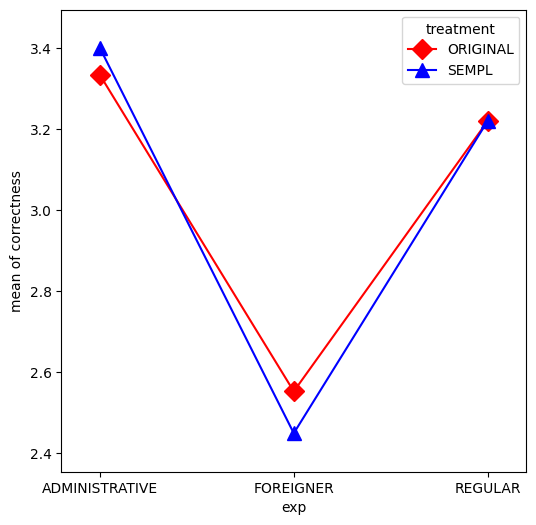

In [28]:
fig, ax = plt.subplots(figsize=(6, 6))
fig = interaction_plot(
    x=tmp['exp'],
    trace=tmp['treatment'],
    response=tmp['correctness'],
    colors=["red", "blue"],
    markers=["D", "^"],
    ms=10,
    ax=ax,
)